In [17]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential


In [18]:
from tensorflow import keras
import PIL
import cv2
import matplotlib.pylab as plt
import numpy as np
from skimage.feature import greycomatrix, greycoprops
import pandas as pd
import pathlib


In [19]:
data_dir=r"C:\Users\COMPUTER CARE\OneDrive\Desktop\kidney(agu)\kidney(agu)"
data_dir = pathlib.Path(data_dir)
images_dict = {
    'Normal': list(data_dir.glob('normal/*')),
    'Cyst': list(data_dir.glob('cyst/*')),
    'Stone': list(data_dir.glob('stone/*')),
    'Tumor': list(data_dir.glob('tumor/*'))
    
}
labels_dict = {
    'Normal':0,
    'Cyst':1,
    'Stone':2,
    'Tumor':3
}

In [20]:
X, Y = [], []
for image_type, images in images_dict.items():
    
        
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        Y.append(labels_dict[image_type])

In [21]:
X=np.array(X)
Y=np.array(Y)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2)

In [23]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet101(include_top=False,input_shape=(224,224,3),
 pooling='avg',classes=4,
 weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(4, activation='softmax'))

In [24]:
    resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 43,709,316
Trainable params: 1,051,140
Non-trainable params: 42,658,176
_________________________________________________________________


In [25]:
resnet_model.compile(
 optimizer="adam",
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 metrics=['accuracy'])
resnet_model.fit(X_train, y_train, epochs=3,steps_per_epoch=50)


Epoch 1/3


C:\Users\COMPUTER CARE\anaconda3\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 844s 17s/step - loss: 1.0911 - accuracy: 0.6938
Epoch 2/3
50/50 [==============================] - 828s 17s/step - loss: 0.2286 - accuracy: 0.9246
Epoch 3/3
50/50 [==============================] - 827s 17s/step - loss: 0.1355 - accuracy: 0.9627


In [26]:
resnet_model.save('resnet101_agu.h5')

In [28]:
resnet_model = tf.keras.models.load_model('resnet101_agu.h5')
resnet_model.evaluate(X_test,y_test)

38/38 [==============================] - 196s 5s/step - loss: 0.1205 - accuracy: 0.9575


[0.12048431485891342, 0.9574999809265137]

In [29]:
predictions=resnet_model.predict(X_test)

38/38 [==============================] - 254s 7s/step


In [30]:
predictions=np.array(predictions)
y_pred=[]
for i in predictions: 
    i=list(i)
    y_pred.append(i.index(max(i[0],i[1],i[2],i[3])))
y_pred=np.array(y_pred)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       274
           1       0.94      0.95      0.95       305
           2       0.93      0.94      0.93       334
           3       0.98      0.98      0.98       287

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



<Axes: >

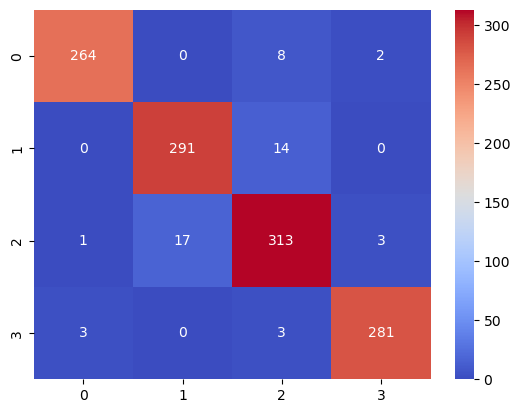

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
cf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(cf_matrix, annot=True,cmap='coolwarm',fmt='.3g')